In [1]:
#=
This script follows the example shown in
https://ieeexplore.ieee.org/document/9068235
=#

include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
# include("./doa/music.jl") # MUSIC
# include("./doa/mpdr.jl") # MVDR

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [8]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/generate_sig.jl")
include("../signal_generator/tone.jl")
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;
c0 = 1500;          # Speed of Medium (in m/s)
freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 1;       # Duration of Tone (in seconds)
sample_rate = 8000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);
new_sig, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, az_gt, c0);
new_sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, az_gt2, c0);
# new_sig3, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, 0, c0);
new_sig .+= new_sig2 #.+ new_sig3;

Start Simulating Signal
Signal has size: (8000, 1)
Using FFT for Delaying
  0.021220 seconds (1.21 k allocations: 14.966 MiB, 34.09% gc time)
Now Generated Signal has size: (8000, 40)
Start Simulating Signal
Signal has size: (8000, 1)
Using FFT for Delaying
  0.013301 seconds (1.21 k allocations: 14.966 MiB)
Now Generated Signal has size: (8000, 40)


8000×40 Matrix{ComplexF64}:
 -0.577928-1.72086im  -1.31732-1.24456im  …  -0.883836-0.831646im
 -0.576673-1.73565im  -1.29794-1.23237im     -0.850627-0.836014im
  -0.57454-1.74779im  -1.27657-1.2183im      -0.816154-0.839225im
 -0.571535-1.75729im  -1.25326-1.20238im     -0.780508-0.841383im
 -0.567669-1.76413im  -1.22804-1.18463im     -0.743842-0.842758im
 -0.562956-1.76834im  -1.20096-1.16511im  …  -0.706555-0.844299im
 -0.557418-1.76995im  -1.17209-1.14386im      -0.67129-0.853174im
  -0.55109-1.76903im   -1.1415-1.12096im     -0.614179-0.803011im
 -0.544037-1.76571im  -1.10931-1.09653im     -0.580221-0.818471im
 -0.536406-1.76035im   -1.0757-1.07083im     -0.539202-0.815576im
          ⋮                               ⋱  
 -0.549584-1.4732im   -1.39817-1.26704im      -1.11658-0.737869im
 -0.556216-1.51044im  -1.39771-1.27238im      -1.09712-0.753045im
 -0.561992-1.54537im  -1.39509-1.27575im      -1.07598-0.767068im
 -0.566904-1.57791im  -1.39032-1.27716im      -1.05318-0.779918im
 -

In [9]:
# include("./utils/preprocess.jl")

#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
freq_interest = freq; # (Hz)
new_S = []
NFFT = size(new_sig, 1);
frequencies = sample_rate/NFFT*(0:(NFFT-1));
(_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );

for signal in eachcol(new_sig)
    S_interest = fft(signal);
    S_interest = S_interest[freq_idx];
    push!(new_S, S_interest);
end

In [10]:
#=
Step 2a: Generate Beamformer Pattern based on Different 
=#
Rx = (1 ./ 1) .* new_S * new_S';
println("\nFor Conventional Beamforming: ");
@time P_cbf, az_list = cbf(Rx, sensors_underwater, freq_interest, c0);
println("\nFor DBF (Coordinate-Free) Beamformer: ")
order = 3;
@time P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq_interest, c0);
# println("\nFor MUSIC Beamformer: ");
# @time P_music, az_list = music(Rx, sensors_underwater, 5, freq_interest, c0); # MUSIC
# println("\nFor MVDR/MPDR Beamformer: ");
# @time P_mvdr, az_list = mvdr(Rx, sensors_underwater, freq_interest, c0); # Technically MPDR
println("\n")


For Conventional Beamforming: 


  0.272454 seconds (947.82 k allocations: 50.437 MiB, 4.53% gc time, 99.03% compilation time)

For DBF (Coordinate-Free) Beamformer: 


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1


ψ has rank 7
  1.869530 seconds (6.06 M allocations: 299.443 MiB, 5.39% gc time, 99.80% compilation time)




In [11]:
#= 
Step 3: Predict the Direction of Arrival based on Maximum Power
=#
using DSP.Util
P_cbf_db, az_cbf_max = predict_az(P_cbf, az_list);
P_dbf_db, az_dbf_max = predict_az(P_dbf, az_list);
# P_music_db, az_music_max = predict_az(P_music, az_list);
# P_mvdr_db, az_mvdr_max = predict_az(P_mvdr, az_list);

println("Predicted Azimuth Angle for CBF: $(az_cbf_max)°");
println("Predicted Azimuth Angle for DBF: $(az_dbf_max)°");

Predicted Azimuth Angle for CBF: -165.0°
Predicted Azimuth Angle for DBF: 126.0°


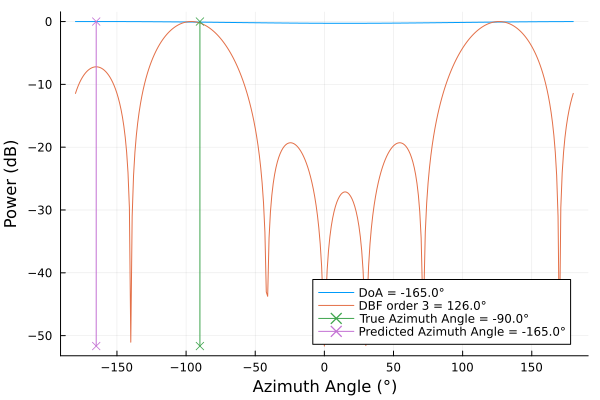

In [13]:
#= 
Step 4: Plot Beamformer Power Spectras
=#
using Plots
ymin = minimum([P_cbf_db; P_dbf_db;]);
plot(az_list, P_cbf_db, label="DoA = $(az_cbf_max)°");
plot!(az_list, P_dbf_db,
        label="DBF order $order = $(az_dbf_max)°");
# plot!(az_list, P_music_db, label="MUSIC DoA = $(az_music_max)°")
# plot!(az_list, P_mvdr_db, label="MVDR DoA = $(az_mvdr_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power (dB)");

# Plot Ground Truth marker
plot!([az_gt, az_gt], [ymin, 0],
    label="True Azimuth Angle = $(az_gt)°",
    marker=:x)
plot!([az_cbf_max, az_cbf_max], [ymin, 0],
    label="Predicted Azimuth Angle = $(az_cbf_max)°",
    marker=:x)
# savefig("./plots/Power_Spectra.png");

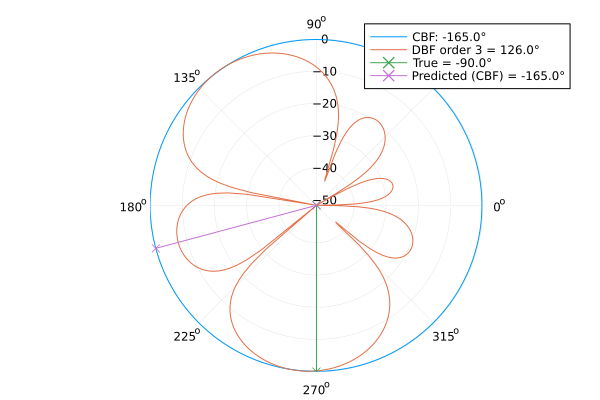

In [15]:
#= 
Step 5: Plot Polar Plots of Beampattern
=#
plot(deg2rad.(az_list), P_cbf_db, proj=:polar, 
        label="CBF: $(az_cbf_max)°");
plot!(deg2rad.(az_list), P_dbf_db, proj =:polar, 
        label="DBF order $(order) = $(az_dbf_max)°",);
# plot!(deg2rad.(az_list), P_music_db, proj=:polar,
#         label="MUSIC: $(az_music_max)°");
# plot!(deg2rad.(az_list), P_mvdr_db, proj=:polar,
#         label="MVDR: $(az_mvdr_max)°");

# Plot Ground Truth marker
plot!(deg2rad.([az_gt, az_gt]),
    [ymin, 0],
    label="True = $(az_gt)°",
    marker=:x);
plot!(deg2rad.([az_cbf_max, az_cbf_max]),
    [ymin, 0],
    label="Predicted (CBF) = $(az_cbf_max)°",
    marker=:x)

ylims!((ymin, maximum(P_cbf_db)));
# savefig("./plots/Beamformer.png");